# TODO:

 - how to use a commong style ?
 - remove local file paths
 - Import/Provide different models
 - Compare plot with:
   - oblivious
   - lightGBM
   - xgboost
   - primi alberi di un modello (quickrank) contro tutti gli alberi

# Topological Analysis

**RankEval** provides topological analysis tools that allow to investigate the shape of a tree-based ensemble. Model shape may unveil possible overfitting behaviours and it may highlight interesting differences among learning algorithms.

In [15]:
# import common libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline

# basic
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Import RankEval topological analysis and visualization packages

In [4]:
from rankeval.analysis.topological import topological_analysis
from rankeval.core.model import RTEnsemble
from rankeval.visualization.topological import plot_tree_shape

##### Load model from file

In [5]:
model_file = "/Users/claudio/docs/LAVORO/coding/ltr/QuickScorer/debug_data/model.lmart.msn1.xml"
model = RTEnsemble(model_file, name="L-Mart.100T")

##### Performing the topological analysis

The method `TopologicalAnalysisResult` computes the topological properties of the given ensemble. It may include or discard tree leaves from the analysis. It returns new object containing:
 - **tree heights**: returns a `scipy` `DescribeResult` object which contains the minimum, maximum, mean depth, etc, of the tree in the given ensemble.
 - **fullness per level**: for each tree level $l$, returns the average number of nodes in the $l$-th level across the whole ensemble divided by $2^l$, where $2^l$ is the maximum possible number of nodes.
 - **average tree shape**: returns a sparse matrix *S*, with *max_depth* rows and *max_nodes* columns. Tree levels, denoted with *l*, are numbered from *0* to *max_depth*. Within each tree level *l*, nodes, denoted with *n*, are numbered left-to-right from *0* to $2^l$. The matrix element *S[l,n]* stores the fraction of trees in the ensemble that have node with id *n* at depth *l*.

In [6]:
# compute analysis
model_stats = topological_analysis(model, include_leaves=False)

# tree heights
print "Tree heights:"
print model_stats.describe_tree_height()
print

# fullness per level
print "Average fullness per level:"
print "Level | Avg. Fullness"
for level,fullness in enumerate (model_stats.fullness_per_level()):
    print "%5d | %.2f" % (level, fullness)
print

# Average tree shape
avg_ts = model_stats.avg_tree_shape()
print "Average tree shape:"
for level in range (min(5,avg_ts.shape[0])):
    print "%5d | " % (level),
    for node in [n for n in range(2**level)]:
        print " %.2f" % (avg_ts[level,node]),
    print
print "  ... |   ....  ...."

Tree heights:
DescribeResult(nobs=100, minmax=(5, 9), mean=8.5099999999999998, variance=0.83828282828282807, skewness=-1.8152708328151126, kurtosis=2.4112297576244286)

Average fullness per level:
Level | Avg. Fullness
    0 | 1.00
    1 | 0.53
    2 | 0.26
    3 | 0.23
    4 | 0.14
    5 | 0.09
    6 | 0.05
    7 | 0.04
    8 | 0.03

Average tree shape:
    0 |   1.00
    1 |   0.96  0.10
    2 |   0.93  0.06  0.05  0.01
    3 |   0.84  0.18  0.04  0.02  0.05  0.00  0.00  0.00
    4 |   0.71  0.13  0.09  0.07  0.04  0.00  0.01  0.01  0.05  0.00  0.00  0.00  0.00  0.00  0.00  0.00
  ... |   ....  ....


### Visualization of Average Tree Shape

**RankEval** provides a specific utility for the visualization of the average tree shape.

In the plot below, the root is represented by the semi-circle at the center of the figure.
Its left and right children are represented left-to-right by two adjacent quarter-circles at tree level 1.
Recursively, the two quadrants illustate the left and right sub-trees of the root.
At each tree level $l$, there are $2^l$ circular trapezoids corresponding to the nodes of a complete tree in left-to-right order.

The color intensity of each circular trapezoid is proportional number of trees that contain the corresponding node.

The model illustrated below is highly imbalanbced towards the left-most path.

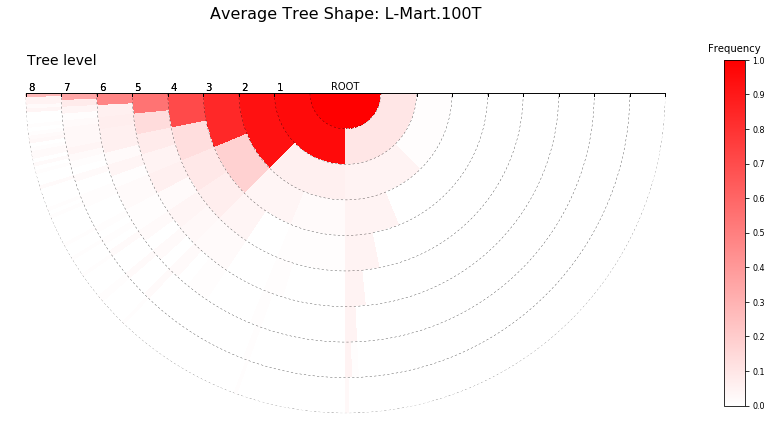

In [17]:
fig, ax = plot_tree_shape(model_stats)